In [1]:
import geopandas as gpd # Geospatial data operations
import rasterio as rio # Geospatial imagery manipulation
import rasterio.plot
import pandas as pd # Tabular data
import os
import re
import rapidfuzz # Fuzzy string matching
from tqdm.auto import tqdm # Progress bars
import matplotlib # Plots
import matplotlib.pyplot as plt
import shapely # Polygon operations
import solaris.tile as tile # Tile splitting
import solaris.data.coco as coco
import contextlib
import io
import rasterio
from rasterio.vrt import WarpedVRT
from rasterio import transform
matplotlib.rcParams['figure.figsize'] = (20, 10)
tqdm.pandas()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 130)

In [2]:
# A complete filelist of the MaxarImagery & Retrolens folders, generated with the unix command:
# find MaxarImagery/ Retrolens/ > ressci201900060-RNC2-Coastal_MaxarImagery_Retrolens_filelist.txt
filelist = pd.read_csv("ressci201900060-RNC2-Coastal_MaxarImagery_Retrolens_filelist.txt", header=None).iloc[:,0]
filelist

0                                                                         MaxarImagery/
1                                                              MaxarImagery/._.DS_Store
2                                                                 MaxarImagery/HighFreq
3                                                       MaxarImagery/HighFreq/HawkesBay
4                                           MaxarImagery/HighFreq/HawkesBay/._.DS_Store
                                              ...                                      
141473            Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_01AUG1942_mosaic.jp2
141474    Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_01AUG1942_mosaic.jp2.aux.xml
141475    Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_22AUG1961_mosaic.tif.aux.xml
141476    Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_20SEP1980_mosaic.jp2.aux.xml
141477        Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_04APR1986_mosaic.jp2.ovr
Name: 0, Length: 141478, dtype: 

In [3]:
def check_filename(filename):
    if "Taranaki" in filename:
        return False
    else:
        # This regex only matches shapefiles that contain something date-like in their names
        match = re.search(r'/Shorelines/\w+\d\w+\d{4}\w*.shp$', filename)
        return bool(match)

df = filelist[filelist.apply(check_filename)].to_frame(name="filename")
df

,filename
1344,MaxarImagery/HighFreq/Nelson/Nelson/Shorelines/Nelson_13DEC2013.shp
1368,MaxarImagery/HighFreq/Nelson/Nelson/Shorelines/Nelson_22NOV2017.shp
1371,MaxarImagery/HighFreq/Nelson/Nelson/Shorelines/Nelson_14DEC2006.shp
1375,MaxarImagery/HighFreq/Nelson/Nelson/Shorelines/Nelson_18MAR2021.shp
1385,MaxarImagery/HighFreq/Nelson/Nelson/Shorelines/Nelson_08FEB2016.shp
...,...
140219,Retrolens/Wellington/KapitiSouth/Shorelines/KapitiSouth_29OCT1973.shp
140221,Retrolens/Wellington/KapitiSouth/Shorelines/KapitiSouth_15APR1966.shp
140224,Retrolens/Wellington/KapitiSouth/Shorelines/KapitiSouth_17APR1952.shp
140278,Retrolens/Wellington/KapitiSouth/Shorelines/KapitiSouth_02JAN1988.shp


In [4]:
images = filelist[filelist.str.contains("/Stack/", case=False) & filelist.str.endswith((".jpg", ".jp2", ".tif"))]
images

236       MaxarImagery/HighFreq/HawkesBay/Mahanga/Imagery/Stack/Mahanga_08NOV2019_2.tif
237       MaxarImagery/HighFreq/HawkesBay/Mahanga/Imagery/Stack/Mahanga_08NOV2019_1.tif
239         MaxarImagery/HighFreq/HawkesBay/Mahanga/Imagery/Stack/Mahanga_12MAR2018.tif
242         MaxarImagery/HighFreq/HawkesBay/Mahanga/Imagery/Stack/Mahanga_31AUG2005.tif
254         MaxarImagery/HighFreq/HawkesBay/Mahanga/Imagery/Stack/Mahanga_25DEC2015.tif
                                              ...                                      
141460            Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_19NOV1972_mosaic.jp2
141466            Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_04APR1986_mosaic.jp2
141469            Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_10NOV1977_mosaic.tif
141470            Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_22AUG1961_mosaic.tif
141473            Retrolens/Wellington/PukeruaBay/Stack/PukeruaBay_01AUG1942_mosaic.jp2
Name: 0, Length: 1904, dtype: ob

In [5]:
# When fuzzy matching, ignore these strings
# _0 will ignore leading zeros in dates
strings_to_delete = ["_mosaic", "_mosiac", "_mosaid", ".mosaic", "_cliff", "_beach", "_beachcliffsegment", "_MF.shp", "_MT.shp", "_0", "_1.tif", "_2.tif", "_3.tif", "_LDS", "_"]

def fuzz_preprocess(filename):
    for s in strings_to_delete:
        filename = filename.replace(s, "")
    # Case-insensitive
    filename = filename.lower()
    # Ignore extension
    filename = os.path.splitext(filename)[0]
    # Basename only
    filename = os.path.basename(filename)
    return filename

def get_matching_image(filename):
    dirname = os.path.dirname(filename)
    RL_dirname = dirname.replace("Stack/", "").replace("Shorelines", "Stack").replace("MaxarImagery/HighFreq", "Retrolens")
    Maxar_dirname = dirname.replace("Imagery/Shorelines", "Imagery/Stack").replace("Shorelines", "Imagery/Stack").replace("Retrolens", "MaxarImagery/HighFreq")
    Maxar_dirname_uppercase = Maxar_dirname.replace("Stack", "STACK")
    Maxar_dirname_outside_Imagery = Maxar_dirname.replace("Imagery/Stack", "Stack")
    all_files_in_folder = images[images.str.startswith((RL_dirname, Maxar_dirname, Maxar_dirname_uppercase, Maxar_dirname_outside_Imagery))]
    if len(all_files_in_folder) == 0:
        return "", 0
    match, score, index = rapidfuzz.process.extractOne(query=filename, choices=all_files_in_folder, processor=fuzz_preprocess)
    return match, score

df["matched_image"], df["match_score"] = zip(*df.filename.apply(get_matching_image))
print("Perfect matches:", sum(df.match_score == 100))
print("Imperfect matches:", sum(df.match_score < 100))
df[["filename", "matched_image", "match_score"]].sort_values(by="match_score").to_csv("shoreline_image_matching.csv", index=False)

Perfect matches: 776
Imperfect matches: 122


In [6]:
def get_meta(row):
    image = rio.open(row.matched_image)
    gdf = gpd.read_file(row.filename)
    row = row.to_dict()
    row["n_lines"] = len(gdf.explode(index_parts=False))
    row.update(image.profile)
    row["GCPs"] = bool(image.gcps)
    return row

metafile = "meta.csv"
if os.path.isfile(metafile):
    meta = pd.read_csv(metafile)
else:
    meta = pd.DataFrame(df.progress_apply(get_meta, axis=1).tolist())
    meta.to_csv("meta.csv", index=False)
meta

,filename,matched_image,match_score,n_lines,driver,dtype,nodata,width,height,count,crs,transform,blockxsize,blockysize,tiled,compress,interleave,GCPs,photometric
0,MaxarImagery/HighFreq/Nelson/Nelson/Shorelines/Nelson_13DEC2013.shp,MaxarImagery/HighFreq/Nelson/Nelson/Imagery/Stack/Nelson_13DEC2013.tif,100.0,4,GTiff,uint8,NaN,8244,5340,3,NaN,"| 0.50, 0.00, 1617063.23|\n| 0.00,-0.50, 5430387.79|\n| 0.00, 0.00, 1.00|",128.0,128,True,lzw,pixel,True,NaN
1,MaxarImagery/HighFreq/Nelson/Nelson/Shorelines/Nelson_22NOV2017.shp,MaxarImagery/HighFreq/Nelson/Nelson/Imagery/Stack/Nelson_22NOV2017.tif,100.0,8,GTiff,uint8,NaN,8244,5340,3,NaN,"| 0.50, 0.00, 1617063.23|\n| 0.00,-0.50, 5430387.79|\n| 0.00, 0.00, 1.00|",128.0,128,True,lzw,pixel,True,NaN
2,MaxarImagery/HighFreq/Nelson/Nelson/Shorelines/Nelson_14DEC2006.shp,MaxarImagery/HighFreq/Nelson/Nelson/Imagery/Stack/Nelson_14DEC2006.tif,100.0,4,GTiff,uint8,NaN,6870,4450,3,NaN,"| 0.60, 0.00, 1617063.43|\n| 0.00,-0.60, 5430387.80|\n| 0.00, 0.00, 1.00|",128.0,128,True,lzw,pixel,True,NaN
3,MaxarImagery/HighFreq/Nelson/Nelson/Shorelines/Nelson_18MAR2021.shp,MaxarImagery/HighFreq/Nelson/Nelson/Imagery/Stack/Nelson_18MAR2021.tif,100.0,4,GTiff,uint8,NaN,8244,5355,3,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.50, 0.00, 1617063.06|\n| 0.00,-0.50, 5430395.29|\n| 0.00, 0.00, 1.00|",128.0,128,True,lzw,pixel,True,NaN
4,MaxarImagery/HighFreq/Nelson/Nelson/Shorelines/Nelson_08FEB2016.shp,MaxarImagery/HighFreq/Nelson/Nelson/Imagery/Stack/Nelson_08FEB2016.tif,100.0,9,GTiff,uint8,NaN,12082,7827,3,NaN,"| 0.34, 0.00, 1617063.16|\n| 0.00,-0.34, 5430388.04|\n| 0.00, 0.00, 1.00|",128.0,128,True,lzw,pixel,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893,Retrolens/Wellington/KapitiSouth/Shorelines/KapitiSouth_29OCT1973.shp,Retrolens/Wellington/KapitiSouth/Stack/KapitiSouth_29OCT1973_mosaic.tif,100.0,6,GTiff,int32,2.147484e+09,8756,25098,1,NaN,"| 0.33, 0.00, 1764342.31|\n| 0.00,-0.33, 5469726.56|\n| 0.00, 0.00, 1.00|",128.0,128,True,NaN,band,True,NaN
894,Retrolens/Wellington/KapitiSouth/Shorelines/KapitiSouth_15APR1966.shp,Retrolens/Wellington/KapitiSouth/Stack/KapitiSouth_15APR1966_mosaic.tif,100.0,5,GTiff,int32,2.147484e+09,13171,34650,1,"PROJCS[""NZGD_2000_Transverse_Mercator"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""GRS 1980"",6378137,2...","| 0.23, 0.00, 1764459.39|\n| 0.00,-0.23, 5469625.71|\n| 0.00, 0.00, 1.00|",128.0,128,True,NaN,band,True,NaN
895,Retrolens/Wellington/KapitiSouth/Shorelines/KapitiSouth_17APR1952.shp,Retrolens/Wellington/KapitiSouth/Stack/KapitiSouth_17APR1952_mosaic.tif,100.0,4,GTiff,int32,2.147484e+09,14167,31280,1,"PROJCS[""NZGD_2000_Transverse_Mercator"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""GRS 1980"",6378137,2...","| 0.27, 0.00, 1763537.25|\n| 0.00,-0.27, 5469157.98|\n| 0.00, 0.00, 1.00|",128.0,128,True,NaN,band,True,NaN
896,Retrolens/Wellington/KapitiSouth/Shorelines/KapitiSouth_02JAN1988.shp,Retrolens/Wellington/KapitiSouth/Stack/KapitiSouth_02JAN1988_mosaic.jp2,100.0,9,JP2OpenJPEG,uint16,2.560000e+02,10654,18819,1,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.39, 0.00, 1762602.58|\n| 0.00,-0.39, 5466346.26|\n| 0.00, 0.00, 1.00|",1024.0,1024,True,NaN,NaN,True,NaN


In [7]:
meta.columns

Index(['filename', 'matched_image', 'match_score', 'n_lines', 'driver',
       'dtype', 'nodata', 'width', 'height', 'count', 'crs', 'transform',
       'blockxsize', 'blockysize', 'tiled', 'compress', 'interleave', 'GCPs',
       'photometric'],
      dtype='object')

In [8]:
meta.driver.value_counts()

JP2OpenJPEG    608
GTiff          289
JPEG             1
Name: driver, dtype: int64

In [9]:
meta["count"].value_counts()

3    838
1     59
4      1
Name: count, dtype: int64

In [10]:
meta.dtype.value_counts()

uint16    596
uint8     288
int32      14
Name: dtype, dtype: int64

In [11]:
meta.nodata.value_counts()

2.560000e+02    596
2.147484e+09     14
2.550000e+02      2
Name: nodata, dtype: int64

In [12]:
coastline = gpd.read_file("lds-nz-coastlines-and-islands-polygons-topo-150k-FGDB.zip!nz-coastlines-and-islands-polygons-topo-150k.gdb")

In [13]:
# Get a random (known-good) annotation
sample = df[df.match_score == 100].sample(1)
display(sample)
image_filename = sample.matched_image.iloc[0]
image = rio.open(image_filename)
sample_gdf = gpd.read_file(sample.filename.iloc[0])
sample_gdf

,filename,matched_image,match_score
93813,Retrolens/Auckland/PakiriBeach_North/Shorelines/PakiriBeach_North_15JAN1977.shp,Retrolens/Auckland/PakiriBeach_North/Stack/PakiriBeach_North_15JAN1977_mosaic.jp2,100.0


,Id,SN,Digitiser,Scale,DSASdate,Region,Site,Notes,Source,geometry
0,0,SN05027,CM,1000,15/01/1977,Auckland,PakiriBeach_North,None,RL,"LINESTRING Z (1748503.311 5996506.962 0.000, 1748480.821 5996494.725 0.000, 1748463.293 5996480.504 0.000, 1748458.332 5996469..."
1,0,SN05027,CM,1000,15/01/1977,Auckland,PakiriBeach_North,None,RL,"LINESTRING Z (1748886.957 5995443.997 0.000, 1748929.952 5995365.614 0.000, 1748972.947 5995292.192 0.000, 1749000.728 5995241..."
2,0,SN05027,CM,1000,15/01/1977,Auckland,PakiriBeach_North,None,RL,"LINESTRING Z (1749471.886 5994514.050 0.000, 1749502.975 5994481.970 0.000, 1749532.740 5994445.589 0.000, 1749552.584 5994414..."
3,0,SN05027,CM,1000,15/01/1977,Auckland,PakiriBeach_North,None,RL,"LINESTRING Z (1749560.191 5994257.404 0.000, 1749610.462 5994224.331 0.000, 1749645.850 5994196.881 0.000, 1749667.348 5994154..."
4,0,SN05027,CM,1000,15/01/1977,Auckland,PakiriBeach_North,None,RL,"LINESTRING Z (1751046.491 5992240.944 0.000, 1751106.353 5992198.280 0.000, 1751126.858 5992188.689 0.000, 1751175.145 5992148..."
5,0,SN05027,CM,1000,15/01/1977,Auckland,PakiriBeach_North,None,RL,"LINESTRING Z (1752231.827 5990828.066 0.000, 1752258.285 5990824.098 0.000, 1752273.829 5990824.759 0.000, 1752290.035 5990822..."


In [14]:
def line_to_split_bbox(geo):
    bounding_box = geo.envelope
    split_bbox = shapely.ops.split(bounding_box, geo)
    return split_bbox

split_bboxes = sample_gdf.geometry.apply(line_to_split_bbox).explode(index_parts=True).reset_index()
#split_bboxes.geometry = split_bboxes.geometry.buffer(0)
split_bboxes["area"] = split_bboxes.area
split_bboxes = split_bboxes[split_bboxes.area > 1e5]
split_bboxes

,level_0,level_1,geometry,area
0,0,0,"POLYGON Z ((1748887.288 5995486.991 0.000, 1748442.457 5995486.991 0.000, 1748442.457 5996378.639 0.000, 1748464.615 5996352.5...",1.946395e+05
1,0,1,"POLYGON Z ((1748503.311 5996506.962 0.000, 1748887.288 5996506.962 0.000, 1748887.288 5995486.991 0.000, 1748877.697 5995508.4...",2.567573e+05
3,1,0,"POLYGON Z ((1749301.031 5994795.766 0.000, 1748886.957 5994795.766 0.000, 1748886.957 5995443.997 0.000, 1748929.952 5995365.6...",1.272227e+05
4,1,1,"POLYGON Z ((1748886.957 5995443.997 0.000, 1749301.031 5995443.997 0.000, 1749301.031 5994795.766 0.000, 1749270.935 5994849.0...",1.411925e+05
7,3,0,"POLYGON Z ((1750839.785 5992494.283 0.000, 1749560.191 5992494.283 0.000, 1749560.191 5994257.404 0.000, 1749610.462 5994224.3...",1.127399e+06
9,3,2,"POLYGON Z ((1749560.191 5994257.404 0.000, 1750845.525 5994257.404 0.000, 1750845.525 5992514.848 0.000, 1750840.895 5992530.0...",1.138741e+06
10,4,0,"POLYGON Z ((1752176.264 5990938.530 0.000, 1751046.491 5990938.530 0.000, 1751046.491 5992240.944 0.000, 1751106.353 5992198.2...",7.781613e+05
11,4,1,"POLYGON Z ((1751046.491 5992240.944 0.000, 1752176.264 5992240.944 0.000, 1752176.264 5990938.530 0.000, 1752173.618 5990949.1...",6.932711e+05


In [15]:
relevant_coastline = coastline.clip(split_bboxes.total_bounds)
split_bboxes["area_inland"] = split_bboxes.clip(relevant_coastline).area
split_bboxes["fraction_inland"] = split_bboxes.area_inland / split_bboxes.area
split_bboxes["class"] = split_bboxes.fraction_inland.apply(lambda f: "land" if f > .5 else "sea")
split_bboxes

/usr/local/lib/python3.8/dist-packages/geopandas/tools/clip.py:63: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/usr/local/lib/python3.8/dist-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


,level_0,level_1,geometry,area,area_inland,fraction_inland,class
0,0,0,"POLYGON Z ((1748887.288 5995486.991 0.000, 1748442.457 5995486.991 0.000, 1748442.457 5996378.639 0.000, 1748464.615 5996352.5...",1.946395e+05,1.946395e+05,1.000000,land
1,0,1,"POLYGON Z ((1748503.311 5996506.962 0.000, 1748887.288 5996506.962 0.000, 1748887.288 5995486.991 0.000, 1748877.697 5995508.4...",2.567573e+05,6.151439e+04,0.239582,sea
3,1,0,"POLYGON Z ((1749301.031 5994795.766 0.000, 1748886.957 5994795.766 0.000, 1748886.957 5995443.997 0.000, 1748929.952 5995365.6...",1.272227e+05,1.272227e+05,1.000000,land
4,1,1,"POLYGON Z ((1748886.957 5995443.997 0.000, 1749301.031 5995443.997 0.000, 1749301.031 5994795.766 0.000, 1749270.935 5994849.0...",1.411925e+05,5.120874e+04,0.362687,sea
7,3,0,"POLYGON Z ((1750839.785 5992494.283 0.000, 1749560.191 5992494.283 0.000, 1749560.191 5994257.404 0.000, 1749610.462 5994224.3...",1.127399e+06,1.127399e+06,1.000000,land
9,3,2,"POLYGON Z ((1749560.191 5994257.404 0.000, 1750845.525 5994257.404 0.000, 1750845.525 5992514.848 0.000, 1750840.895 5992530.0...",1.138741e+06,2.327926e+05,0.204430,sea
10,4,0,"POLYGON Z ((1752176.264 5990938.530 0.000, 1751046.491 5990938.530 0.000, 1751046.491 5992240.944 0.000, 1751106.353 5992198.2...",7.781613e+05,7.781613e+05,1.000000,land
11,4,1,"POLYGON Z ((1751046.491 5992240.944 0.000, 1752176.264 5992240.944 0.000, 1752176.264 5990938.530 0.000, 1752173.618 5990949.1...",6.932711e+05,7.238467e+04,0.104410,sea


(5990938.530253513, 5996506.962223711)

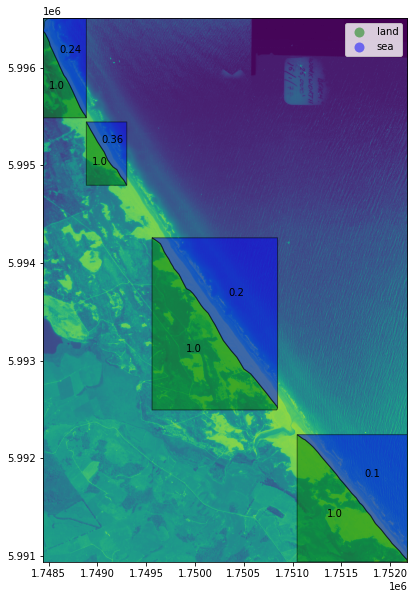

In [16]:
# Plot the results, and check it all looks ok
fig, ax = plt.subplots()
ax = rasterio.plot.show(image, ax=ax)

cmap = matplotlib.colors.ListedColormap(['green', 'blue'])
split_bboxes.plot(ax=ax, alpha=.5, column='class', cmap=cmap, categorical=True, legend=True, edgecolor='black')
split_bboxes.apply(lambda x: ax.annotate(text=round(x.fraction_inland, 2), xy=x.geometry.centroid.coords[0], ha='center'), axis=1)

#relevant_coastline.plot(ax=ax, alpha=.5, edgecolor="cyan")

b = split_bboxes.total_bounds
xlim = ([b[0], b[2]])
ylim = ([b[1], b[3]])
ax.set_xlim(xlim)
ax.set_ylim(ylim)